# SQUANCH Demonstration
## Attenuated superdense coding down a fiber optic cable

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

%matplotlib inline

from squanch import qstream, qubit, gates, agent

import cProfile, re
import time

In [3]:
fiberOpticAttenuation = -0.16  # dB/km, from Yin, et al, Satellite-based entanglement
cableLength = 1  # km, let's just call it this for now 
# Total attenuation along the fiber, equal to probability of receiving a photon
decibelLoss = cableLength * fiberOpticAttenuation
cableAttenuation = 10 ** (decibelLoss / 10)


def attenuatedSuperdenseTransmission(bit1, bit2, qStream):
    # Alice prepares a two-qubit system
    AB = qStream.pop()
    
    alice, bob = AB.qubits

    # Prepare the bell pair
    gates.H(alice)
    AB.apply(gates._CNOT)

    # Alice sends the first qubit to Bob - if it is attenuated, return 0,0
    # if np.random.rand() > cableAttenuation:
    #     return 0, 0

    # Alice encodes her bits
    if bit2 == 1:
        gates.X(alice)
    if bit1 == 1:
        gates.Z(alice)

    # Alice sends her qubit to bob and then he decodes the bits
    # if np.random.rand() > cableAttenuation:
    #     return 0, 0
    AB.apply(gates._CNOT)
    gates.H(alice)

    # Measure the results
    outputBit1 = alice.measure()
    outputBit2 = bob.measure()

    return outputBit1, outputBit2

def attenuatedIntTransmission(value, qStream):
    '''Transmit an 8-bit unsigned integer value including attenuation effects'''
    bits = np.unpackbits(np.array([value], dtype=np.uint8))
    receivedBits = np.zeros(8, dtype=np.uint8)
    
    for i in range(4):
        b1, b2 = attenuatedSuperdenseTransmission(bits[2 * i], bits[2 * i + 1], qStream)
        receivedBits[2 * i] = b1
        receivedBits[2 * i + 1] = b2
        
    return np.packbits(receivedBits)[0]

def attenuatedArrayTransmission(array):
    bitsToSend = array.size * 8 * np.dtype(np.uint8).itemsize
    numQuantumSystems = bitsToSend / 2
    
    qs = qstream.QStream(2, numQuantumSystems)
    
    receivedArray = np.zeros(array.shape, dtype=np.uint8)
    iterator = np.nditer(array, flags=['multi_index'])

    while not iterator.finished:
        # if iterator.iterindex % 10000 == 0:
        #     print "Iteration {}/{}".format(iterator.iterindex, iterator.itersize)
        receivedElement = attenuatedIntTransmission(iterator[0], qs)
        receivedArray[iterator.multi_index] = receivedElement
        iterator.iternext()
    return receivedArray

Original image:


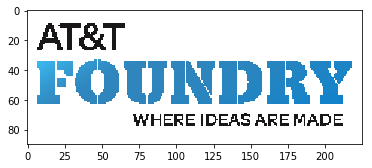

In [3]:
# Let's try transmitting the following image: 
imgData = mp.image.imread("img/foundryLogo.bmp") 
print "Original image:"
plt.imshow(imgData)

Reconstructed transmitted image accounting for attenuation effects:


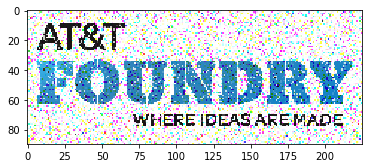

In [4]:
# Transmit the image with the attenuated superdense protocol
receivedArray = attenuatedArrayTransmission(imgData)
print "Reconstructed transmitted image accounting for attenuation effects:"
plt.imshow(receivedArray)

Original image:


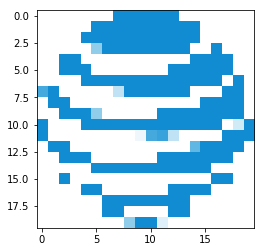

In [3]:
# Let's try transmitting the following image: 
imgData = mp.image.imread("img/attLogo.bmp") 
print "Original image:"
plt.imshow(imgData)

Reconstructed transmitted image accounting for attenuation effects: (elapsed time: 0.689192056656 sec)


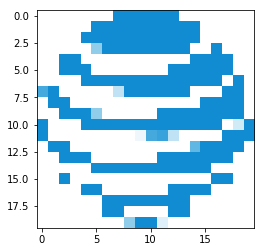

In [5]:
# Transmit the image with the attenuated superdense protocol
start = time.time()
receivedArray = attenuatedArrayTransmission(imgData)
stop = time.time()
print "Reconstructed transmitted image accounting " \
      "for attenuation effects: (elapsed time: {} sec)".format(stop-start)
plt.imshow(receivedArray)

In [42]:
transmissionRate = receivedArray.nbytes / (stop - start)
print "Transmission rate: {}B/s".format(transmissionRate)

Transmission rate: 5191.26744569B/s


Original image:


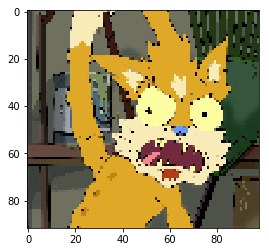

In [4]:
# Let's try transmitting the following image: 
imgData = mp.image.imread("img/squanchy.bmp") 
print "Original image:"
plt.imshow(imgData)

Reconstructed transmitted image accounting for attenuation effects: (elapsed time: 11.2679400444 sec)


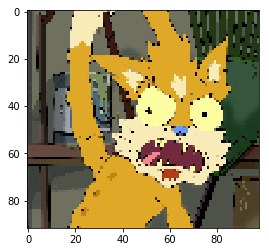

In [5]:
# Transmit the image with the attenuated superdense protocol
start = time.time()
receivedArray = attenuatedArrayTransmission(imgData)
stop = time.time()
print "Reconstructed transmitted image accounting " \
      "for attenuation effects: (elapsed time: {} sec)".format(stop-start)
plt.imshow(receivedArray)

## Demonstration of new agent and channel formulism 

0.000s: Charlie distributing bell pairs...


4.854s: Alice encoding her data and sending to Bob...


8.802s: Bob disentangling and reading out quantum data...


17.572s: Simulation of 216384-bit transmission complete.


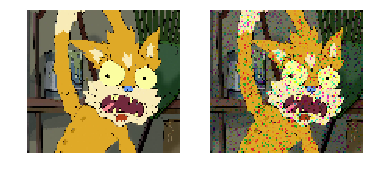

In [18]:
# Load the image 
imgData = mp.image.imread("img/squanchy.bmp")

# Create Alice, Bob, and Charlie as agents. 
# Charlie will distribute Bell pairs to Alice and Bob, and Alice will send the 
# image data to Bob using these distributed pairs.
alice = agent.Agent("Alice")
bob = agent.Agent("Bob")
charlie = agent.Agent("Charlie")

# Connect Alice, Bob, and Charlie. Charlie is at the midpoint of Alice and Bob, 
# who are 1km apart from each other.
agent.connectAgents(alice, bob, length = 1.0)
agent.connectAgents(alice, charlie, length = 0.5)
agent.connectAgents(bob, charlie, length = 0.5)

def charlieDistributesBellPair(qStream):
    # Get the qubits from the next system to distribute
    pair = qStream.head()
    qa, qb = pair.qubits

    # Prepare the bell pair 
    gates.H(qa)
    pair.apply(gates._CNOT)

    # Send the photons in the bell pair to Alice and Bob
    charlie.qsend(alice, qa)
    charlie.qsend(bob, qb)

    # Alice and Bob receive their qubits 
    alice.qrecv(charlie)
    bob.qrecv(charlie)

def aliceEncodesBitPair(bit1, bit2):
    # Retrieve the next of Charlie's qubits from Alice's quantum memory 
    qubit = alice.qmem[charlie].pop(0)

    # If the qubit is not corrupted, Alice encodes her bits
    if qubit is not None:
        if bit2 == 1:
            gates.X(qubit)
        if bit1 == 1:
            gates.Z(qubit)

    # Alice sends the qubit to Bob 
    alice.qsend(bob, qubit)
    # Bob receives his qubit from Alice
    bob.qrecv(alice)

def bobDecodesBitPair():
    # Retrieve Alice's and Charlie's qubuts from Bob's quantum memory 
    qa = bob.qmem[alice].pop(0)
    qc = bob.qmem[charlie].pop(0)

    # If either qubit is corrupted, replace both bits with 0
    if qa is None or qc is None:
        return 0, 0

    # Bob disentangles the qubits 
    qa.qSystem.apply(gates._CNOT)
    gates.H(qa)

    # Measure the results
    bit1 = qa.measure()
    bit2 = qc.measure()
    return bit1, bit2

# Convert an array to a bitstream
aliceBits = np.unpackbits(imgData)
bobBits = np.zeros(aliceBits.size, dtype = np.uint8)
# Instantiate the QStream object of proper size 
numQuantumSystems = len(aliceBits) / 2
qs = qstream.QStream(2, numQuantumSystems)

# Start the timer for the actual function calls
start = time.time()

# Charlie distributes bell pairs 
print "{:.3f}s: Charlie distributing bell pairs...".format(time.time() - start)
for _ in range(numQuantumSystems):
    charlieDistributesBellPair(qs)

# Alice and Bob now have entangled pairs stored in their quantum memory
# Some time later, Alice encodes her data and sends to Bob 
print "{:.3f}s: Alice encoding her data and sending to Bob...".format(time.time() - start)
for i in range(numQuantumSystems):
    aliceEncodesBitPair(aliceBits[2 * i], aliceBits[2 * i + 1])

# Bob decodes and reads out the data
print "{:.3f}s: Bob disentangling and reading out quantum data...".format(time.time() - start)
for i in range(numQuantumSystems):
    bobBits[2 * i], bobBits[2 * i + 1] = bobDecodesBitPair()

# Stop the timer 
stop = time.time()
print "{:.3f}s: Simulation of {}-bit transmission complete.".format(stop - start, len(bobBits))

# Repackage the received data in an image format
receivedArray = np.reshape(np.packbits(bobBits), imgData.shape)

# Plot the data 
f, ax = plt.subplots(1, 2)
ax[0].imshow(imgData)
ax[0].axis('off')
ax[1].imshow(receivedArray)
ax[1].axis('off')
plt.show()